In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yahooFinance

In [2]:
spy_df = yahooFinance.Ticker("SPY").history(start="2005-01-01", end="2017-01-01")
spy_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2005-01-03 00:00:00-05:00,83.966599,84.104750,82.819970,83.096268,55748000,0.0,0.0,0.0
2005-01-04 00:00:00-05:00,83.206795,83.262055,81.811498,82.080887,69167600,0.0,0.0,0.0
2005-01-05 00:00:00-05:00,82.018719,82.370999,81.507572,81.514481,65667300,0.0,0.0,0.0
2005-01-06 00:00:00-05:00,81.811492,82.301918,81.687158,81.928917,47814700,0.0,0.0,0.0
2005-01-07 00:00:00-05:00,82.177585,82.357180,81.597359,81.811493,55847700,0.0,0.0,0.0


In [3]:
class StockTicker:

    def __init__(self, df):
        self.df = df
        self.index = 0
        self.date = df.index[self.index]

    def next_day(self):
        self.index += 1
        self.date = self.df.index[self.index]

    def get_price(self):
        return self.df.loc[self.date].Close

    def get_date(self):
        return self.date

    def get_price_history(self, days):
        if days <= 0:
            raise ValueError("days must be greater than 0")
        days = min(days, self.index+1)
        return self.df.loc[spy_df.index[self.index-days+1]: spy_df.index[self.index]].Close

    def get_prev_price(self):
        return self.df.loc[self.index - 1].Close

    def get_next_price(self):
        return self.df.loc[self.index + 1].Close

spy_ticker = StockTicker(spy_df)

In [4]:
# have a class to hold information about holding, cash, and portfolio value
class Trader:

    def __init__(self, cash, stock_ticker, commision=0):
        self.cash = cash
        self.holdings = 0 # number of shares of SPY
        self.stock_ticker = stock_ticker
        self.commision = commision

    def __str__(self):
        return f"Cash: {self.cash}, SPY Holding: {self.holdings}"

    def portfolio_value(self):
        return self.cash + self.stock_ticker.get_price() * self.holdings

    def buy(self, amount):
        # commision is a % of the amount
        if self.cash < amount * (1 + self.commision):
            amount = self.cash / (1 + self.commision)
        price = self.stock_ticker.get_price()
        self.holdings += amount / price
        self.cash -= amount * (1 + self.commision)

    def sell(self, amount):
        if self.holdings < amount:
            amount = self.holdings
        price = self.stock_ticker.get_price()
        self.holdings -= amount
        self.cash += amount * price * (1 - self.commision)

In [5]:
class GoldenAndDeathCrossStrategy:

    def __init__(self, stock_ticker, short_window, long_window, threshold):
        self.stock_ticker = stock_ticker
        self.short_window = short_window
        self.long_window = long_window
        self.threshold = threshold
        self.signal = []

        self.slow_avg = []
        self.long_avg = []

    def get_signal(self):
        if self.stock_ticker.index < self.long_window - 1:
            self.signal.append("hold")
            self.slow_avg.append(None)
            self.long_avg.append(None)
            return None

        prev_short_avg = self.stock_ticker.get_price_history(self.short_window+1)[:self.short_window].mean()
        prev_long_avg = self.stock_ticker.get_price_history(self.long_window+1)[:self.long_window].mean()
        short_avg = self.stock_ticker.get_price_history(self.short_window).mean()
        long_avg = self.stock_ticker.get_price_history(self.long_window).mean()

        self.slow_avg.append(short_avg)
        self.long_avg.append(long_avg)

        if short_avg > long_avg * (1 + self.threshold) and prev_short_avg < prev_long_avg * (1 + self.threshold):
            self.signal.append("buy")
            return "buy"
        if short_avg < long_avg * (1 - self.threshold) and prev_short_avg > prev_long_avg * (1 - self.threshold):
            self.signal.append("sell")
            return "sell"
        self.signal.append("hold")
        return None


In [6]:
golden_death_cross = GoldenAndDeathCrossStrategy(spy_ticker, 30, 200, 0.01)

In [7]:
from collections import defaultdict

START_CASH = 10000
TRADING_DAYS = 2000
AMOUNT_BOUGHT_PER_DAY = START_CASH / TRADING_DAYS

trader_benchmark = Trader(START_CASH, spy_ticker, commision=0)
trader_benchmark.buy(trader_benchmark.cash)

trader_commision = Trader(START_CASH, spy_ticker, commision=0.05)
trader_no_commision = Trader(START_CASH, spy_ticker, commision=0)
trader_death_cross = Trader(START_CASH, spy_ticker, commision=0.05)

portfolio_values = defaultdict(list)

for i in range(TRADING_DAYS):
    trader_commision.buy(AMOUNT_BOUGHT_PER_DAY)
    trader_no_commision.buy(AMOUNT_BOUGHT_PER_DAY)

    signal = golden_death_cross.get_signal()
    if signal == "buy":
        trader_death_cross.buy(trader_death_cross.cash/2)
    elif signal == "sell":
        trader_death_cross.sell(trader_death_cross.holdings/2)

    portfolio_values[trader_benchmark].append(trader_benchmark.portfolio_value())
    portfolio_values[trader_commision].append(trader_commision.portfolio_value())
    portfolio_values[trader_no_commision].append(trader_no_commision.portfolio_value())
    portfolio_values[trader_death_cross].append(trader_death_cross.portfolio_value())

    spy_ticker.next_day()

In [8]:
spy_ticker.get_price_history(2000).values

array([ 82.08088684,  81.51448059,  81.92891693, ..., 115.00470734,
       115.78771973, 115.84422302])

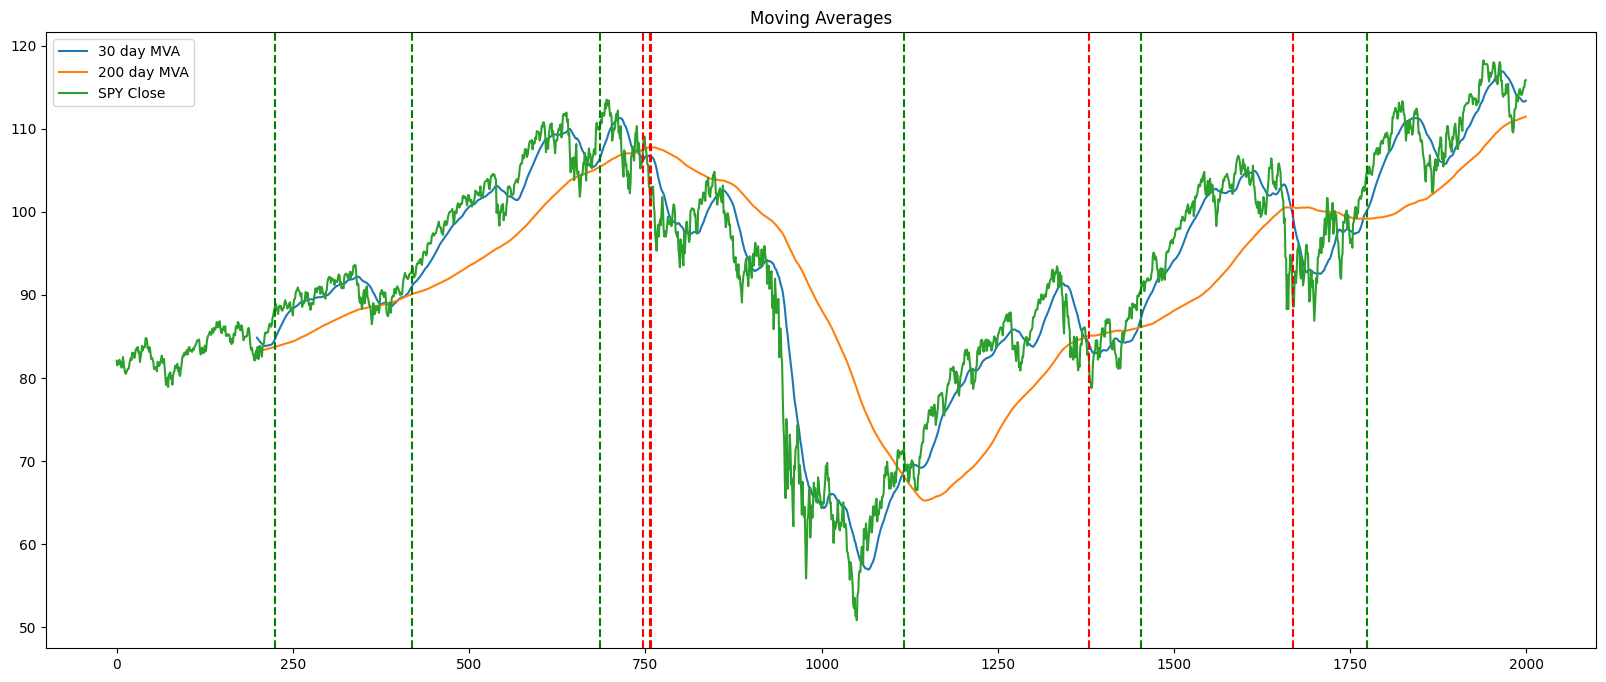

In [9]:
# plot mva values
plt.figure(figsize=(20, 8))
plt.plot(golden_death_cross.slow_avg, label="30 day MVA")
plt.plot(golden_death_cross.long_avg, label="200 day MVA")
plt.plot(spy_ticker.get_price_history(2000).values, label="SPY Close")

for i in range(len(golden_death_cross.signal)):
    if golden_death_cross.signal[i] == "buy":
        plt.axvline(x=i, color='g', linestyle='--')
    if golden_death_cross.signal[i] == "sell":
        plt.axvline(x=i, color='r', linestyle='--')

plt.title("Moving Averages")
plt.legend()
plt.show()

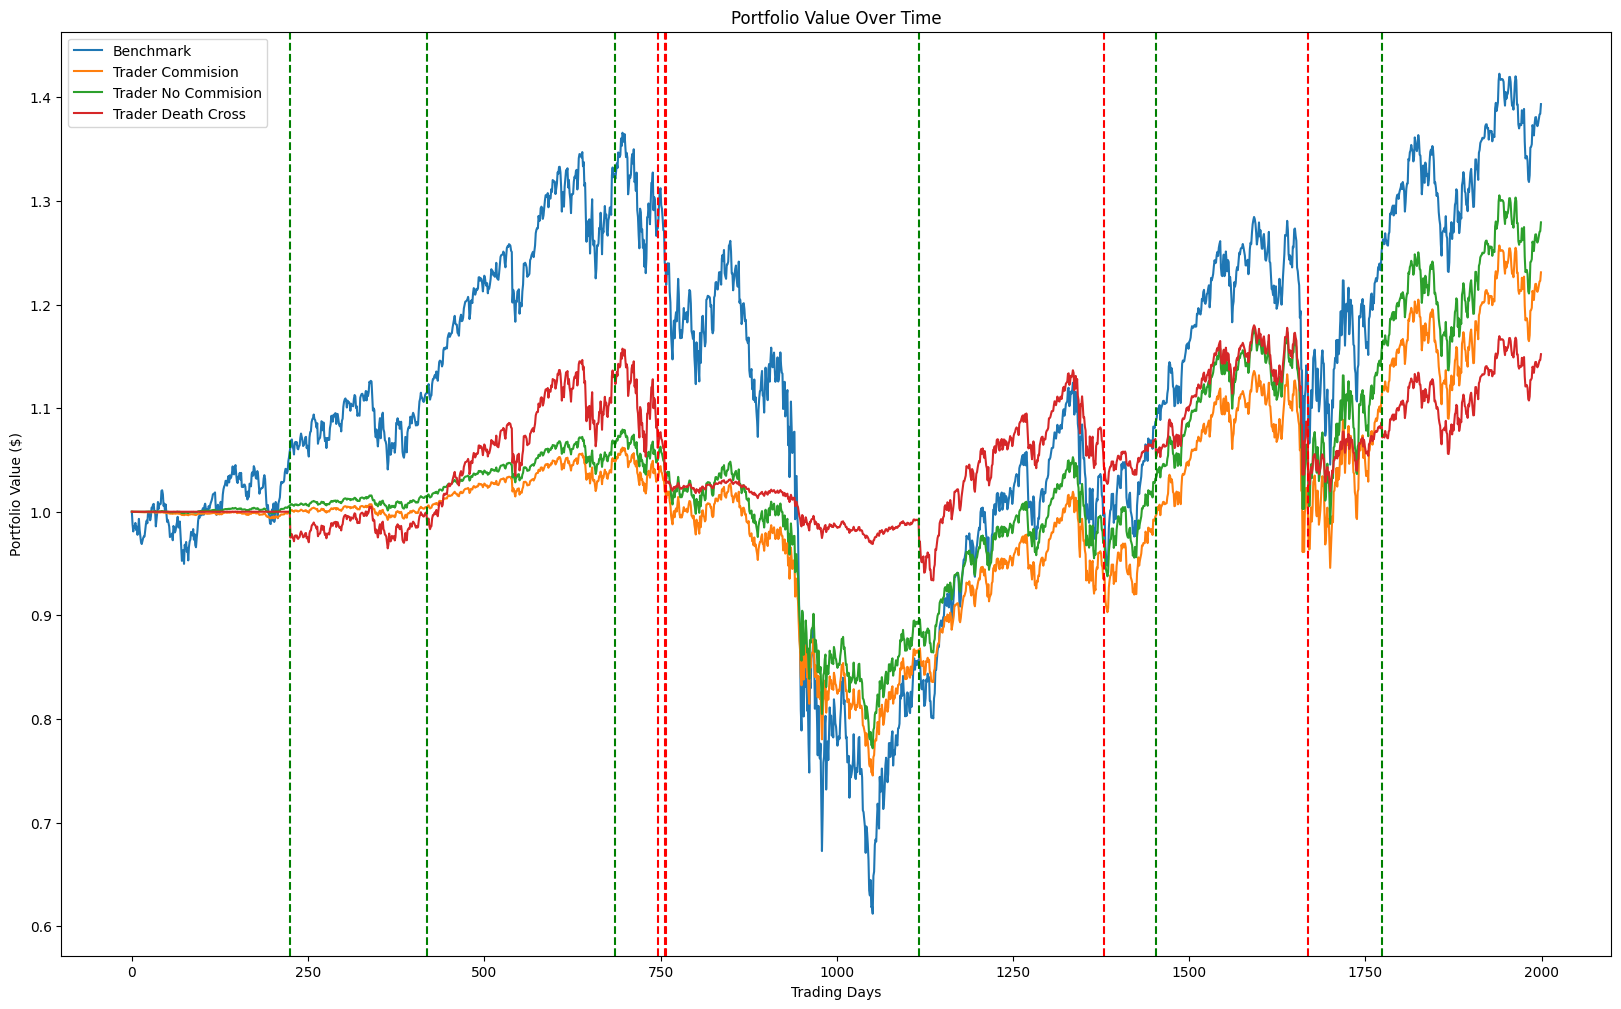

In [10]:
plt.figure(figsize=(20, 12))

plt.plot(np.array(portfolio_values[trader_benchmark])/START_CASH, label="Benchmark")
plt.plot(np.array(portfolio_values[trader_commision])/START_CASH, label="Trader Commision")
plt.plot(np.array(portfolio_values[trader_no_commision])/START_CASH, label="Trader No Commision")
plt.plot(np.array(portfolio_values[trader_death_cross])/START_CASH, label="Trader Death Cross")

# show axvline of death cross
for i, signal in enumerate(golden_death_cross.signal):
    if signal == "sell":
        plt.axvline(x=i, color="red", linestyle="--")
    elif signal == "buy":
        plt.axvline(x=i, color="green", linestyle="--")

plt.title("Portfolio Value Over Time")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value ($)")
# plt.yscale("log")
plt.legend()
plt.show()